In [1]:
import os
import sys
sys.path.insert(0, '..')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from authenticate_service_account import main
from utils import preprocess, create_train_test_split, preprocess_test_set


In [2]:
# client = main()

# query = """
# SELECT *
# FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
# """

# query_job = client.query(query)

# results = query_job.result()


In [3]:
# data = results.to_dataframe()


In [4]:
# data.to_csv('one_week.csv')


In [5]:
data = pd.read_csv('one_week.csv')


In [6]:
data.columns


Index(['Unnamed: 0', 'OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
  

In [7]:
# data[(data['ODRedirects'] == 10) & (data['TravelHorizonDays'] <15)].to_csv('small_ods.csv')


In [8]:
itin = data

itin = preprocess(itin, ['OriginCty', 'DestinationCty'], ['OriginCtry', 'DestinationCtry'], True)


<Axes: xlabel='ODRedirects', ylabel='OriginCtry'>

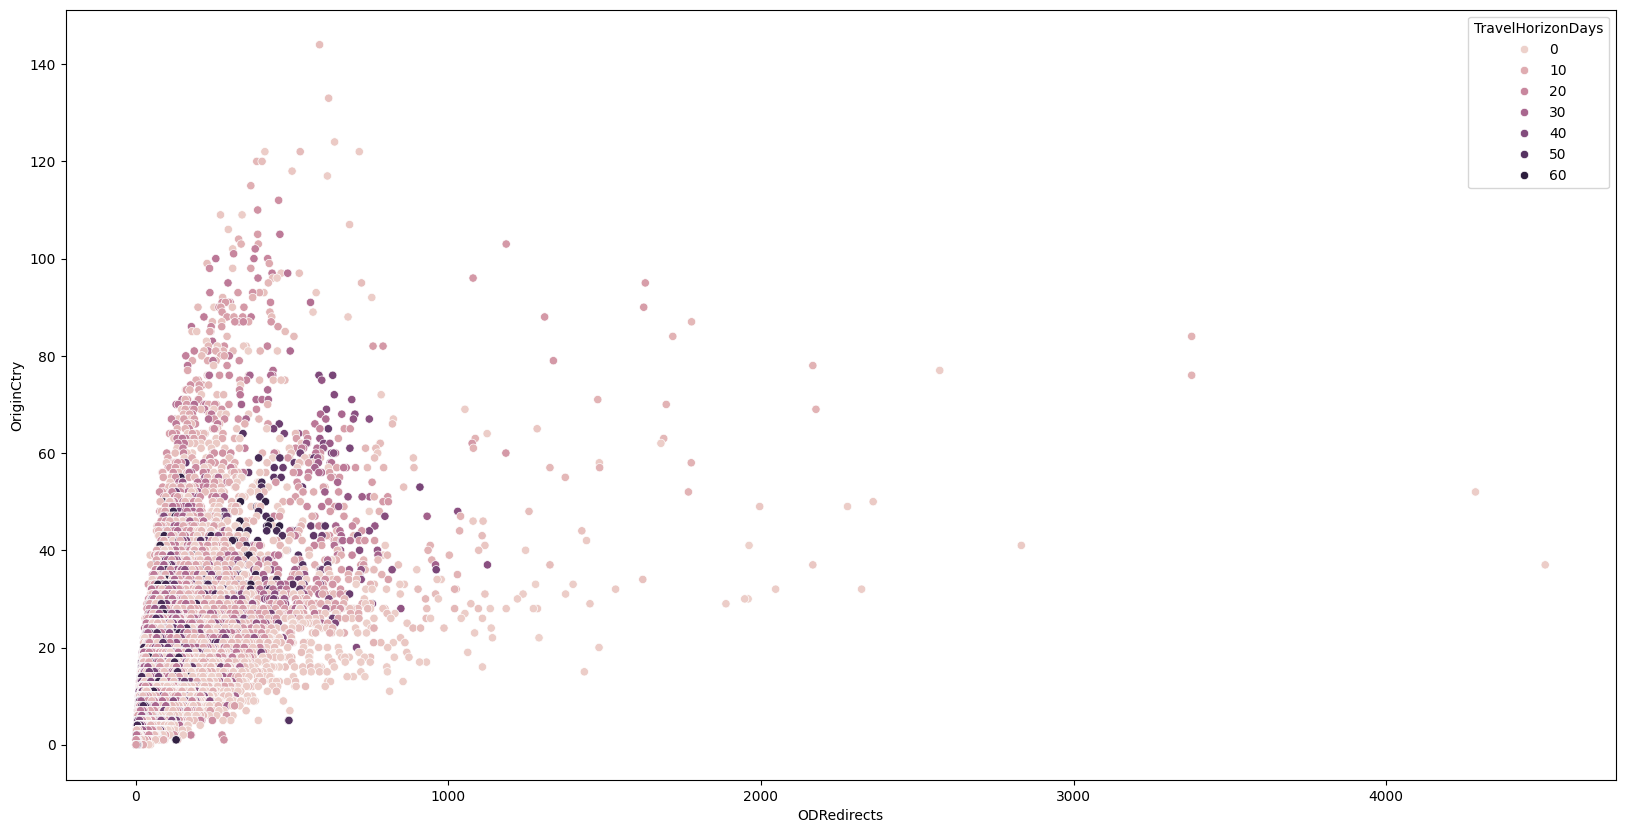

In [18]:
plt.figure(figsize=(20,10))
data = itin.groupby(['OD', 'TravelHorizonDays', 'ODRedirects']).count()['OriginCtry'].reset_index().sort_values('OriginCtry', ascending=False)
sns.scatterplot(data=data, x='ODRedirects', y='OriginCtry', hue='TravelHorizonDays')


In [16]:
itin[(itin['OD'] == 'DXBLON') & (itin['TravelHorizonDays'] == 5)].sort_values('ItineraryRedirects', ascending=False).to_csv('DXBLON.csv')


In [14]:
itin[(itin['ODRedirects'] == 10) & (itin['TravelHorizonDays'] <15)].to_csv('small_ods.csv')


<Axes: >

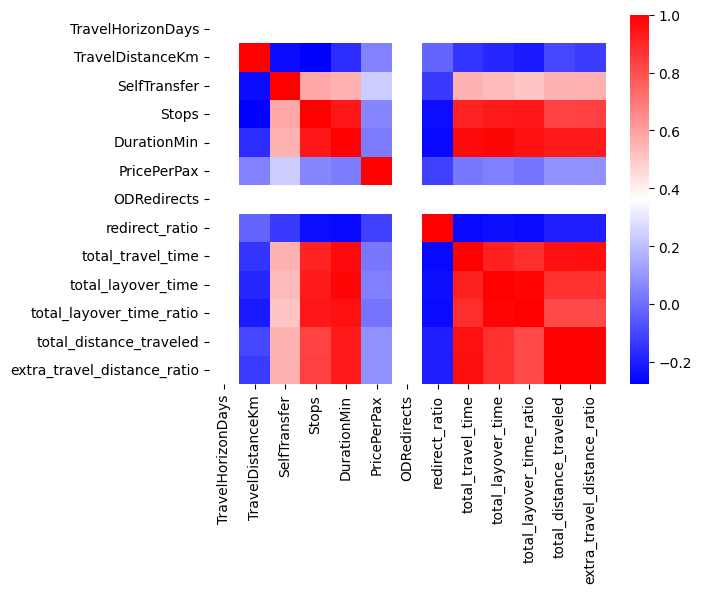

In [21]:
itin = itin[['OD', 'OD_ctry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin', 'PricePerPax', 'ODRedirects', 'redirect_ratio', 'total_travel_time', 'total_layover_time', 'total_layover_time_ratio', 'total_distance_traveled', 'extra_travel_distance_ratio']]

corr_matrix = itin[(itin['OD'] == 'LONNYC') & (itin['TravelHorizonDays'] == 10) ].drop(columns=['OD', 'OD_ctry']).corr()
column_names = corr_matrix.columns
sns.heatmap(corr_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr")


In [12]:
# Converting the correlation matrix into a DataFrame
corr_df = corr_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

# Computing the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# Showing the top 5 most correlated pairs of feature
corr_df[corr_df['feature_1'] == 'redirect_ratio'].sort_values(by="absolute_correlation", ascending=False)


,feature_1,feature_2,correlation,absolute_correlation
61,redirect_ratio,total_travel_time,-0.253583,0.253583
58,redirect_ratio,DurationMin,-0.252332,0.252332
63,redirect_ratio,total_layover_time_ratio,-0.249728,0.249728
57,redirect_ratio,Stops,-0.244816,0.244816
62,redirect_ratio,total_layover_time,-0.241633,0.241633
64,redirect_ratio,total_distance_traveled,-0.198523,0.198523
65,redirect_ratio,extra_travel_distance_ratio,-0.197516,0.197516
56,redirect_ratio,SelfTransfer,-0.130723,0.130723
59,redirect_ratio,PricePerPax,-0.113451,0.113451
55,redirect_ratio,TravelDistanceKm,-0.024792,0.024792


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import category_encoders as ce
from tensorflow.keras import Sequential, layers, models


In [130]:
itin_model = itin[['OD_ctry', 'TravelHorizonDays', 'TravelDistanceKm', 'ODRedirects',
       'SelfTransfer', 'Stops', 'DurationMin', 'redirect_ratio',
       'total_layover_time_ratio', 'extra_travel_distance_ratio']]

itin_model = itin_model[(itin_model['TravelDistanceKm'].notna())]
#itin_model = itin_model[(itin_model['OD_ctry'].notna()) & (itin_model['ODRedirects'] > 99)]


In [131]:


data_cty = data[['OriginCty','DestinationCty']]

# Initialize BinaryEncoder
binary_encoder = ce.BinaryEncoder(cols=['OriginCty'])

# Fit and transform the data
binary_encoded_data = binary_encoder.fit_transform(data_cty)

# Print the result
print("Binary Encoded data:")
print(binary_encoded_data)


Binary Encoded data:
         OriginCty_0  OriginCty_1  OriginCty_2  OriginCty_3  OriginCty_4  \
0                  0            0            0            0            0   
1                  0            0            0            0            0   
2                  0            0            0            0            0   
3                  0            0            0            0            0   
4                  0            0            0            0            0   
...              ...          ...          ...          ...          ...   
4093549            0            0            1            1            0   
4093550            0            0            1            1            0   
4093551            0            0            1            1            0   
4093552            0            0            1            1            0   
4093553            0            0            1            1            0   

         OriginCty_5  OriginCty_6  OriginCty_7  OriginCty_8  Origi

In [132]:
data_cty['OriginCty'].unique()


array(['SSA', 'SSG', 'SSH', ..., 'KAW', 'CXI', 'GGW'], dtype=object)

In [133]:
# Handle categorical variables (label encoding)
# Initialize BinaryEncoder
binary_encoder = ce.BinaryEncoder(cols=['OD_ctry'])

# Fit and transform the data
itin_model_encoded = binary_encoder.fit_transform(itin_model)
itin_model_encoded.columns


Index(['OD_ctry_0', 'OD_ctry_1', 'OD_ctry_2', 'OD_ctry_3', 'OD_ctry_4',
       'OD_ctry_5', 'OD_ctry_6', 'OD_ctry_7', 'OD_ctry_8', 'OD_ctry_9',
       'OD_ctry_10', 'OD_ctry_11', 'OD_ctry_12', 'OD_ctry_13',
       'TravelHorizonDays', 'TravelDistanceKm', 'ODRedirects', 'SelfTransfer',
       'Stops', 'DurationMin', 'redirect_ratio', 'total_layover_time_ratio',
       'extra_travel_distance_ratio'],
      dtype='object')

In [134]:
itin_model_encoded = itin_model_encoded.apply(lambda col: col.astype(float) if col.dtype != float else col)

itin_model_encoded.dtypes


OD_ctry_0                      float64
OD_ctry_1                      float64
OD_ctry_2                      float64
OD_ctry_3                      float64
OD_ctry_4                      float64
OD_ctry_5                      float64
OD_ctry_6                      float64
OD_ctry_7                      float64
OD_ctry_8                      float64
OD_ctry_9                      float64
OD_ctry_10                     float64
OD_ctry_11                     float64
OD_ctry_12                     float64
OD_ctry_13                     float64
TravelHorizonDays              float64
TravelDistanceKm               float64
ODRedirects                    float64
SelfTransfer                   float64
Stops                          float64
DurationMin                    float64
redirect_ratio                 float64
total_layover_time_ratio       float64
extra_travel_distance_ratio    float64
dtype: object

In [135]:
scaler = RobustScaler()

itin_model_encoded['TravelHorizonDays'] = scaler.fit_transform(itin_model_encoded['TravelHorizonDays'].values.reshape(-1, 1))
itin_model_encoded['TravelDistanceKm'] = scaler.fit_transform(itin_model_encoded['TravelDistanceKm'].values.reshape(-1, 1))
itin_model_encoded['ODRedirects'] = scaler.fit_transform(itin_model_encoded['ODRedirects'].values.reshape(-1, 1))
itin_model_encoded['DurationMin'] = scaler.fit_transform(itin_model_encoded['DurationMin'].values.reshape(-1, 1))


In [136]:

X_test, X_train, y_test, y_train = create_train_test_split(itin_model_encoded, 'redirect_ratio')


In [137]:
# Initialize the RandomForestRegressor model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
random_forest_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [129]:
# Make predictions on the test set
y_pred = random_forest_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mae:.4f}')
print(f'R^2 Score: {r2:.2f}')


Mean Squared Error: 0.1330
R^2 Score: 0.71


In [87]:
# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(itin_model_encoded.drop(columns=['redirect_ratio']).columns, feature_importances):
    print(f"{feature}: {importance:.4f}")


Feature Importances:
OD_ctry_0: 0.0131
OD_ctry_1: 0.0312
OD_ctry_2: 0.0115
OD_ctry_3: 0.0160
OD_ctry_4: 0.0198
OD_ctry_5: 0.0241
OD_ctry_6: 0.0237
OD_ctry_7: 0.0236
OD_ctry_8: 0.0232
OD_ctry_9: 0.0216
OD_ctry_10: 0.0251
OD_ctry_11: 0.0228
OD_ctry_12: 0.0201
OD_ctry_13: 0.0248
TravelHorizonDays: 0.1601
SelfTransfer: 0.0120
Stops: 0.0072
DurationMin: 0.2463
total_layover_time_ratio: 0.1405
extra_travel_distance_ratio: 0.1331


In [24]:
model_accs = []
for idx, tree in enumerate(random_forest_model.estimators_):
    model_accs.append(tree.score(X_test, y_test))


/Users/felix/.pyenv/versions/3.12.0/envs/OptiFlyAI/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/felix/.pyenv/versions/3.12.0/envs/OptiFlyAI/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/felix/.pyenv/versions/3.12.0/envs/OptiFlyAI/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/felix/.pyenv/versions/3.12.0/envs/OptiFlyAI/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/felix/.pyenv/versions/3.12.0/envs/OptiFlyAI/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegre

In [25]:
model_accs = np.array(model_accs)
model_accs


array([0.16289863, 0.24442216, 0.13388146, 0.18805062, 0.16814107,
       0.21650511, 0.16751659, 0.18842989, 0.18220915, 0.14735015,
       0.19012844, 0.11406693, 0.12714703, 0.1446515 , 0.16728379,
       0.19379051, 0.15540293, 0.13940568, 0.17567059, 0.16115504,
       0.17895306, 0.06816803, 0.18428639, 0.18409132, 0.15235515,
       0.17033722, 0.13173902, 0.17011387, 0.20243941, 0.13037244,
       0.21196391, 0.13634017, 0.13650333, 0.19263902, 0.17685244,
       0.13666611, 0.16788652, 0.1738807 , 0.13056412, 0.13381198,
       0.15198125, 0.16083972, 0.18916243, 0.19504913, 0.18566702,
       0.1710504 , 0.12989086, 0.12186735, 0.18036369, 0.19923064,
       0.20474546, 0.1210126 , 0.18350864, 0.17140007, 0.22004065,
       0.19222272, 0.18717218, 0.14220262, 0.20762138, 0.07938352,
       0.18420522, 0.15244645, 0.17394996, 0.17176983, 0.17872847,
       0.17392757, 0.16506359, 0.16153997, 0.1260885 , 0.10279056,
       0.12258128, 0.18000923, 0.16251976, 0.21474043, 0.17889

In [18]:
from tensorflow.keras import Sequential, layers


In [101]:
model = Sequential()


In [102]:
model.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                736       
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])


In [104]:
model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/15
2690/2690 [==============================] - 9s 3ms/step - loss: 0.1076 - mean_absolute_error: 0.2722 - val_loss: 0.0899 - val_mean_absolute_error: 0.2308
Epoch 2/15
2690/2690 [==============================] - 8s 3ms/step - loss: 0.0728 - mean_absolute_error: 0.2146 - val_loss: 0.0583 - val_mean_absolute_error: 0.1922
Epoch 3/15
2690/2690 [==============================] - 7s 3ms/step - loss: 0.0550 - mean_absolute_error: 0.1828 - val_loss: 0.0489 - val_mean_absolute_error: 0.1729
Epoch 4/15
2690/2690 [==============================] - 7s 3ms/step - loss: 0.0483 - mean_absolute_error: 0.1679 - val_loss: 0.0504 - val_mean_absolute_error: 0.1664
Epoch 5/15
2690/2690 [==============================] - 7s 3ms/step - loss: 0.0450 - mean_absolute_error: 0.1601 - val_loss: 0.0439 - val_mean_absolute_error: 0.1550
Epoch 6/15
2690/2690 [==============================] - 7s 3ms/step - loss: 0.0434 - mean_absolute_error: 0.1559 - val_loss: 0.0401 - val_mean_absolute_error: 0.1504
Epoc

In [56]:
y_pred = model.predict(X_test)


21516/21516 [==============================] - 11s 490us/step


In [74]:
result_df = pd.concat([pd.DataFrame(X_test).reset_index(), pd.Series(y_test, name='True Values').reset_index(), pd.Series(y_pred.flatten(), name='Predictions')], axis=1)
result_df.head(20)


,index,OD_ctry_0,OD_ctry_1,OD_ctry_2,OD_ctry_3,OD_ctry_4,OD_ctry_5,OD_ctry_6,OD_ctry_7,OD_ctry_8,...,TravelDistanceKm,ODRedirects,SelfTransfer,Stops,DurationMin,total_layover_time_ratio,extra_travel_distance_ratio,index,True Values,Predictions
0,2275442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.264212,-0.307692,0.0,1.0,-0.100917,0.275000,1.001936,2275442,1.000000,0.942590
1,3437264,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.765832,1.153846,0.0,0.0,0.807339,0.000000,1.000000,3437264,0.205128,0.069490
2,1698976,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.301915,0.576923,1.0,1.0,0.266055,0.237500,1.008460,1698976,0.083333,0.081821
3,1538613,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.125184,-0.076923,0.0,0.0,-0.045872,0.000000,1.000000,1538613,0.142857,0.324735
4,1058655,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.103387,-0.115385,0.0,0.0,-0.183486,0.000000,1.000000,1058655,0.500000,0.372341
5,532112,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,2.347865,-0.307692,1.0,2.0,3.229358,0.498759,1.252298,532112,1.000000,0.857583
6,2583735,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.234168,0.115385,0.0,0.0,0.486239,0.000000,1.000000,2583735,0.416667,0.240484
7,1207846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.375258,-0.269231,1.0,0.0,-0.321101,0.000000,1.000000,1207846,0.500000,0.550681
8,3714276,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.998527,2.500000,0.0,2.0,1.577982,0.313901,1.070224,3714276,0.027027,-0.029820
9,3402838,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.213255,-0.307692,0.0,0.0,-0.247706,0.000000,1.000000,3402838,1.000000,0.943478


In [63]:
result_df[result_df['OD_ctry_0'].isna()]


,OD_ctry_0,OD_ctry_1,OD_ctry_2,OD_ctry_3,OD_ctry_4,OD_ctry_5,OD_ctry_6,OD_ctry_7,OD_ctry_8,OD_ctry_9,...,TravelHorizonDays,TravelDistanceKm,ODRedirects,SelfTransfer,Stops,DurationMin,total_layover_time_ratio,extra_travel_distance_ratio,True Values,Predictions
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.942590
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069490
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.081821
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.324735
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.857583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.170682
688480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084497
688481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151331
688482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061558


In [73]:
X_test.reset_index().index


RangeIndex(start=0, stop=688487, step=1)

In [68]:
y_test.index


Index([2275442, 3437264, 1698976, 1538613, 1058655,  532112, 2583735, 1207846,
       3714276, 3402838,
       ...
        653527,  262784, 3484275,  525168, 3065283, 1234091, 1743032,  627098,
       3193104,  580250],
      dtype='int64', length=688487)

In [72]:
pd.Series(y_pred.flatten()).index


RangeIndex(start=0, stop=688487, step=1)

In [75]:
result_df['diff'] = result_df['True Values'] - result_df['Predictions']


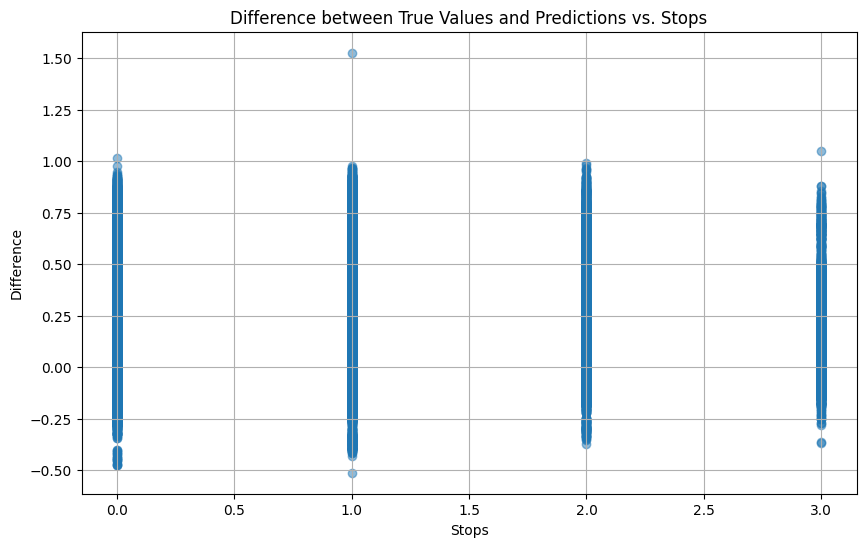

In [78]:
feature_column = 'Stops'

# Plot the difference between true values and predictions against the specific feature
plt.figure(figsize=(10, 6))
plt.scatter(result_df[feature_column], result_df['diff'], alpha=0.5)
plt.title('Difference between True Values and Predictions vs. {}'.format(feature_column))
plt.xlabel(feature_column)
plt.ylabel('Difference')
plt.grid(True)
plt.show()


In [139]:
test_set  = pd.read_csv('/Users/felix/code/LaGenace/OptiFlyAI/test_set.csv')


In [140]:
clean_test = test_set.drop_duplicates()


In [16]:
test_set = pd.read_csv('bookings_test_set.csv')
test_set.columns


Index(['flights', 'origin', 'destination', 'connection_airport',
       'total_minutes', 'connection_time', 'days_to_travel', 'pax', 'bookings',
       'total_price', 'total_distance', 'direct_distance'],
      dtype='object')

In [17]:
test_set_cleaned = preprocess_test_set(test_set)


In [18]:
scaler = MinMaxScaler()
scaler.fit(test_set_cleaned)
test_set_scaled = scaler.transform(test_set_cleaned)


In [19]:
adoko_model = models.load_model('new_target_model03Dec23.h5')


In [20]:
predictions = adoko_model.predict(test_set_scaled)


117/117 [==============================] - 0s 702us/step


In [23]:
test_set['predictions'] = predictions
test_set.to_csv('test_predictions.csv')


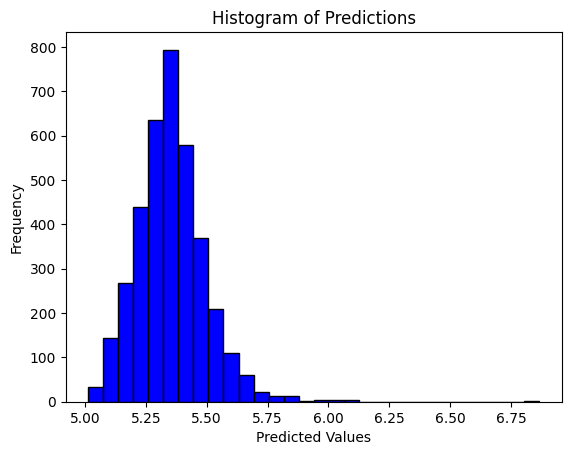

In [22]:
plt.hist(predictions, bins=30, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions')

# Show the plot
plt.show()
